### 1. Imports and Setup

In [1]:
# Essentials libraries
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA = Path("../data_work/loans_merged.parquet")
OUT_CLEAN = Path("../data_work/loans_cleaned.parquet")
RESULTS = Path("../results")
TABLES = RESULTS / "tables"
RESULTS.mkdir(exist_ok=True)
TABLES.mkdir(exist_ok=True)
FIG_PATH = Path("../results/figures")
FIG_PATH.mkdir(parents=True, exist_ok=True)
out_csv = Path("../results/tables/hypothesis_tests.csv")
out_md  = Path("../results/data_quality_report.md")
out_csv.parent.mkdir(parents=True, exist_ok=True)

TS = datetime.utcnow().strftime("%Y-%m-%d %H:%M UTC")
print("Session:", TS)

Session: 2025-12-01 00:02 UTC


/var/folders/g6/cvn07_654_vd6n7331v9tm200000gn/T/ipykernel_94809/2711510459.py:13: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  TS = datetime.utcnow().strftime("%Y-%m-%d %H:%M UTC")


### 2. Load Merged Dataset


In [3]:
df = pd.read_parquet(DATA)
print("Rows:", len(df))
df.head(3)

Rows: 2260668


,id,issue_d,issue_q_start,loan_amnt,term_m,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,purpose,dti,fico,target,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS
0,61548863,2015-10-01,2015-10-01,10000,36,0.0789,312.859985,A,A5,10.0,RENT,37000.0,credit_card,33.669998,705,1,18892.206,5.033333,237.837,0.16
1,61429137,2015-10-01,2015-10-01,35000,36,0.0818,1099.689941,B,B1,4.0,RENT,120000.0,credit_card,17.580000,730,1,18892.206,5.033333,237.837,0.16
2,61308389,2015-10-01,2015-10-01,18000,60,0.1099,391.279999,B,B4,5.0,RENT,50000.0,credit_card,22.540001,710,1,18892.206,5.033333,237.837,0.16


In [4]:
df.columns

Index(['id', 'issue_d', 'issue_q_start', 'loan_amnt', 'term_m', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'purpose', 'dti', 'fico', 'target', 'GDPC1', 'UNRATE',
       'CPIAUCSL', 'FEDFUNDS'],
      dtype='object')

### 3. Cleaning and Preprocessing

In [5]:
# numeric coercion
num_cols = ["loan_amnt","term_m","int_rate","installment", "emp_length", "annual_inc","dti",
            "fico","GDPC1","UNRATE","CPIAUCSL","FEDFUNDS"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")


In [6]:
# winsorize obvious outliers
bounds = dict(
    int_rate=(0, 1), term_m=(12, 84), loan_amnt=(500, 80_000), installment=(0, 5_000),
    annual_inc=(0, 1_000_000), dti=(0, 200), fico=(300, 900),
    UNRATE=(0, 30), FEDFUNDS=(-5, 25), CPIAUCSL=(50, 4000), GDPC1=(1_000, 50_000)
)
for c,(lo,hi) in bounds.items():
    if c in df.columns: df[c] = df[c].clip(lo, hi)

In [7]:
# essential rows only
core = ["loan_amnt","term_m","int_rate","annual_inc","dti","fico","target"]
df = df.dropna(subset=core)

In [8]:
print("Rows:", len(df))

Rows: 2258953


In [9]:
# fill installment by term median
if "installment" in df.columns:
    df["installment"] = df.groupby("term_m")["installment"].transform(lambda s: s.fillna(s.median()))


# --- Fix emp_length missing handling ---
if "emp_length" in df.columns:
    # Impute with overall median 
    df["emp_length"].fillna(df["emp_length"].median())



In [10]:
df['emp_length'].dtype

dtype('float32')

In [11]:
# Normalize categorical text columns (clean case, spacing, and missing values)
for c in ["grade","sub_grade","home_ownership","purpose"]:
    if c in df.columns:
        df[c] = (
            df[c]
            .astype(str)          # ensure string type
            .str.strip()          # remove leading/trailing spaces
            .str.lower()          # make lowercase for consistency
            .replace({"": "unknown", "nan": "unknown"})  # handle blanks/NaNs
        )

In [12]:
df.head(2)

,id,issue_d,issue_q_start,loan_amnt,term_m,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,purpose,dti,fico,target,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS
0,61548863,2015-10-01,2015-10-01,10000,36,0.0789,312.859985,a,a5,10.0,rent,37000.0,credit_card,33.669998,705,1,18892.206,5.033333,237.837,0.16
1,61429137,2015-10-01,2015-10-01,35000,36,0.0818,1099.689941,b,b1,4.0,rent,120000.0,credit_card,17.580000,730,1,18892.206,5.033333,237.837,0.16


In [13]:
# reorder columns
final = [
    "id","issue_d","issue_q_start",
    "loan_amnt","term_m","int_rate","installment","annual_inc",
    "dti","fico",
    "grade","sub_grade","emp_length","home_ownership","purpose",
    "GDPC1","UNRATE","CPIAUCSL","FEDFUNDS","target"
]
df = df[[c for c in final if c in df.columns]]
df.to_parquet(OUT_CLEAN, index=False)
print("Saved:", OUT_CLEAN, "→", len(df), "rows")

Saved: ../data_work/loans_cleaned.parquet → 2258953 rows


In [14]:
print(f"Saved data: {df.shape}")

Saved data: (2258953, 20)


In [15]:
df.head()

,id,issue_d,issue_q_start,loan_amnt,term_m,int_rate,installment,annual_inc,dti,fico,grade,sub_grade,emp_length,home_ownership,purpose,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS,target
0,61548863,2015-10-01,2015-10-01,10000,36,0.0789,312.859985,37000.0,33.669998,705,a,a5,10.0,rent,credit_card,18892.206,5.033333,237.837,0.16,1
1,61429137,2015-10-01,2015-10-01,35000,36,0.0818,1099.689941,120000.0,17.580000,730,b,b1,4.0,rent,credit_card,18892.206,5.033333,237.837,0.16,1
2,61308389,2015-10-01,2015-10-01,18000,60,0.1099,391.279999,50000.0,22.540001,710,b,b4,5.0,rent,credit_card,18892.206,5.033333,237.837,0.16,1
3,60547906,2015-10-01,2015-10-01,9000,36,0.0818,282.779999,75000.0,22.020000,730,b,b1,10.0,mortgage,credit_card,18892.206,5.033333,237.837,0.16,0
4,61308501,2015-10-01,2015-10-01,20575,60,0.1655,506.380005,78000.0,24.139999,700,d,d2,10.0,rent,other,18892.206,5.033333,237.837,0.16,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2258953 entries, 0 to 2260667
Data columns (total 20 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              object        
 1   issue_d         datetime64[ns]
 2   issue_q_start   datetime64[us]
 3   loan_amnt       int32         
 4   term_m          int16         
 5   int_rate        float64       
 6   installment     float64       
 7   annual_inc      float64       
 8   dti             float64       
 9   fico            int32         
 10  grade           object        
 11  sub_grade       object        
 12  emp_length      float32       
 13  home_ownership  object        
 14  purpose         object        
 15  GDPC1           float64       
 16  UNRATE          float64       
 17  CPIAUCSL        float64       
 18  FEDFUNDS        float64       
 19  target          int32         
dtypes: datetime64[ns](1), datetime64[us](1), float32(1), float64(8), int16(1), int32(3), object(5)


In [17]:
df.describe()

,issue_d,issue_q_start,loan_amnt,term_m,int_rate,installment,annual_inc,dti,fico,emp_length,GDPC1,UNRATE,CPIAUCSL,FEDFUNDS,target
count,2258953,2258953,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.113644e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06,2.258953e+06
mean,2016-05-02 07:02:41.891815424,2016-04-02 10:53:00.710000,1.504388e+04,4.290806e+01,1.309198e-01,4.457259e+02,7.755192e+04,1.872460e+01,6.985788e+02,5.976423e+00,1.915688e+04,5.046595e+00,2.415637e+02,7.295409e-01,1.192097e-01
min,2007-06-01 00:00:00,2007-04-01 00:00:00,5.000000e+02,3.600000e+01,5.310000e-02,4.930000e+00,0.000000e+00,0.000000e+00,6.100000e+02,5.000000e-01,1.626915e+04,3.766667e+00,2.066310e+02,7.333333e-02,0.000000e+00
25%,2015-04-01 00:00:00,2015-04-01 00:00:00,8.000000e+03,3.600000e+01,9.490000e-02,2.516100e+02,4.600000e+04,1.189000e+01,6.750000e+02,2.000000e+00,1.878224e+04,4.166667e+00,2.369600e+02,1.366667e-01,0.000000e+00
50%,2016-07-01 00:00:00,2016-07-01 00:00:00,1.290000e+04,3.600000e+01,1.262000e-01,3.778900e+02,6.500000e+04,1.784000e+01,6.900000e+02,6.000000e+00,1.919794e+04,4.900000e+00,2.406073e+02,3.966667e-01,0.000000e+00
75%,2017-11-01 00:00:00,2017-10-01 00:00:00,2.000000e+04,6.000000e+01,1.599000e-01,5.930600e+02,9.300000e+04,2.449000e+01,7.150000e+02,1.000000e+01,1.988235e+04,5.433333e+00,2.472383e+02,1.203333e+00,0.000000e+00
max,2018-12-01 00:00:00,2018-10-01 00:00:00,4.000000e+04,6.000000e+01,3.099000e-01,1.719830e+03,1.000000e+06,2.000000e+02,8.450000e+02,1.000000e+01,2.030487e+04,9.933333e+00,2.527110e+02,5.250000e+00,1.000000e+00
std,NaN,NaN,9.188072e+03,1.086611e+01,4.831389e-02,2.671100e+02,5.432038e+04,1.044305e+01,3.300445e+01,3.650615e+00,8.177724e+02,1.168990e+00,6.832682e+00,6.996577e-01,3.240351e-01


### 4. EDA Visual Implementation

#### A. Borrower Profile Visuals

In [18]:
# ensure consistent theme
sns.set_theme(style="whitegrid", palette="deep")

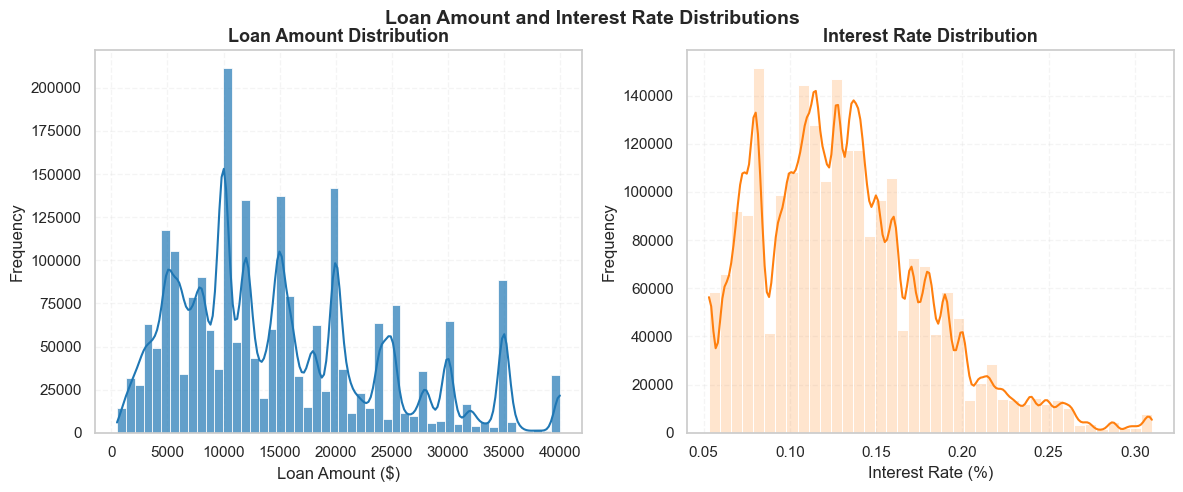

In [19]:
# 1. Loan Amount and Interest Rate Distribution

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.set_theme(style="whitegrid")

# Left: Loan Amount Distribution
sns.histplot(
    df["loan_amnt"], 
    bins=50, kde=True, 
    color="#1f77b4",  # blue tone
    alpha=0.7, ax=ax[0]
)
ax[0].set_title("Loan Amount Distribution", fontsize=13, weight="bold")
ax[0].set_xlabel("Loan Amount ($)")
ax[0].set_ylabel("Frequency")
ax[0].grid(True, linestyle="--", alpha=0.2)

# Right: Interest Rate Distribution
sns.histplot(
    df["int_rate"], 
    bins=40, kde=True, 
    color="#ff7f0e",  # orange tone
    alpha=0.2, ax=ax[1]
)
ax[1].set_title("Interest Rate Distribution", fontsize=13, weight="bold")
ax[1].set_xlabel("Interest Rate (%)")
ax[1].set_ylabel("Frequency")
ax[1].grid(True, linestyle="--", alpha=0.2)

plt.suptitle("Loan Amount and Interest Rate Distributions", fontsize=14, weight="bold")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(FIG_PATH / "loan_amount_interest.png", dpi=300, bbox_inches="tight")
plt.show()


/Users/binodtandan/UNT Research/ai_stress_testing/venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


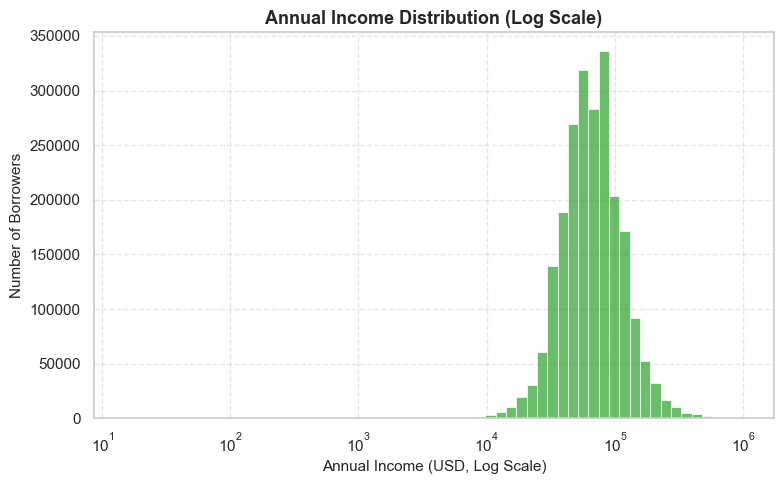

In [20]:
# 2. Annual Income (Log Scale)

plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid")

sns.histplot(
    df["annual_inc"],
    bins=60,
    log_scale=True,
    kde=True,                 
    color="#2ca02c",          
    alpha=0.7,
    edgecolor="white", 
    linewidth=0.5
)

plt.title("Annual Income Distribution (Log Scale)", fontsize=13, weight="bold")
plt.xlabel("Annual Income (USD, Log Scale)", fontsize=11)
plt.ylabel("Number of Borrowers", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(FIG_PATH / "annual_income.png", dpi=300, bbox_inches="tight")
plt.show()


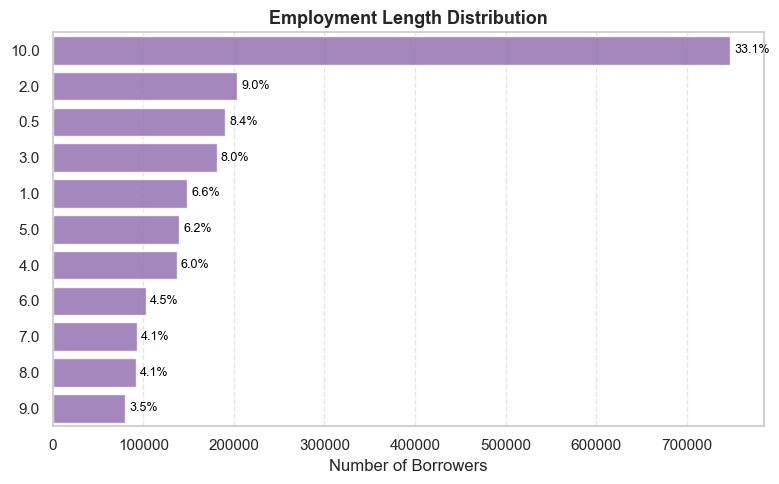

In [21]:
# 3. Employment Length Distribution 

plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid")

# Order bars by frequency
order = df["emp_length"].value_counts().index

ax = sns.countplot(
    y="emp_length",
    data=df,
    order=order,
    color="#9467bd",       
    alpha=0.85,
    edgecolor="white"
)

# Add percentage labels on each bar
total = len(df)
for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f"{(v.get_width()/total)*100:.1f}%" for v in container],
        label_type="edge",
        fontsize=9,
        color="black",
        padding=3
    )

# Titles and layout
ax.set_title("Employment Length Distribution", fontsize=13, weight="bold")
ax.set_xlabel("Number of Borrowers")
ax.set_ylabel("")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(FIG_PATH / "emp_length_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


#### B. Loan Performance vs Default

/var/folders/g6/cvn07_654_vd6n7331v9tm200000gn/T/ipykernel_94809/2181236743.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


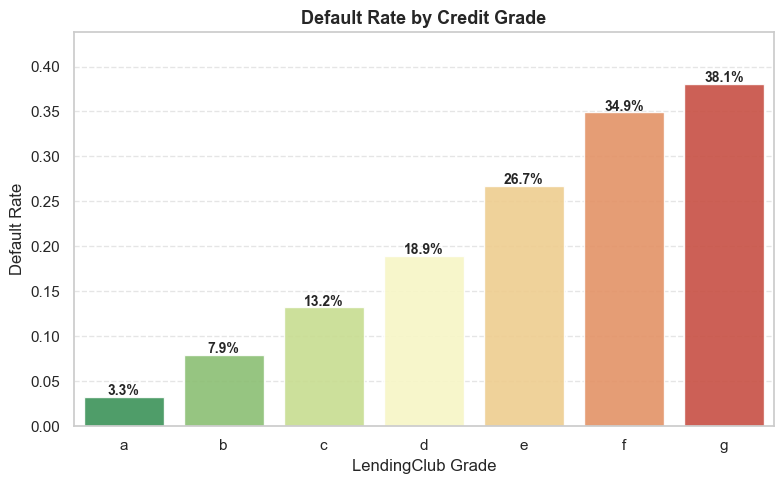

In [22]:
# 4. Default Rate by Grade

grade_default = df.groupby("grade")["target"].mean().sort_index()

plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    x=grade_default.index,
    y=grade_default.values,
    palette="RdYlGn_r",  # Red (high risk) → Green (low risk)
    alpha=0.9,
    edgecolor="white"
)

# Add percentage labels above each bar
for i, val in enumerate(grade_default.values):
    ax.text(i, val + 0.002, f"{val*100:.1f}%", ha="center", fontsize=10, weight="semibold")

# Titles and styling
ax.set_title("Default Rate by Credit Grade", fontsize=13, weight="bold")
ax.set_xlabel("LendingClub Grade")
ax.set_ylabel("Default Rate")
ax.set_ylim(0, grade_default.max() * 1.15)
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(FIG_PATH / "default_rate_by_grade.png", dpi=300, bbox_inches="tight")
plt.show()



/var/folders/g6/cvn07_654_vd6n7331v9tm200000gn/T/ipykernel_94809/1362341601.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


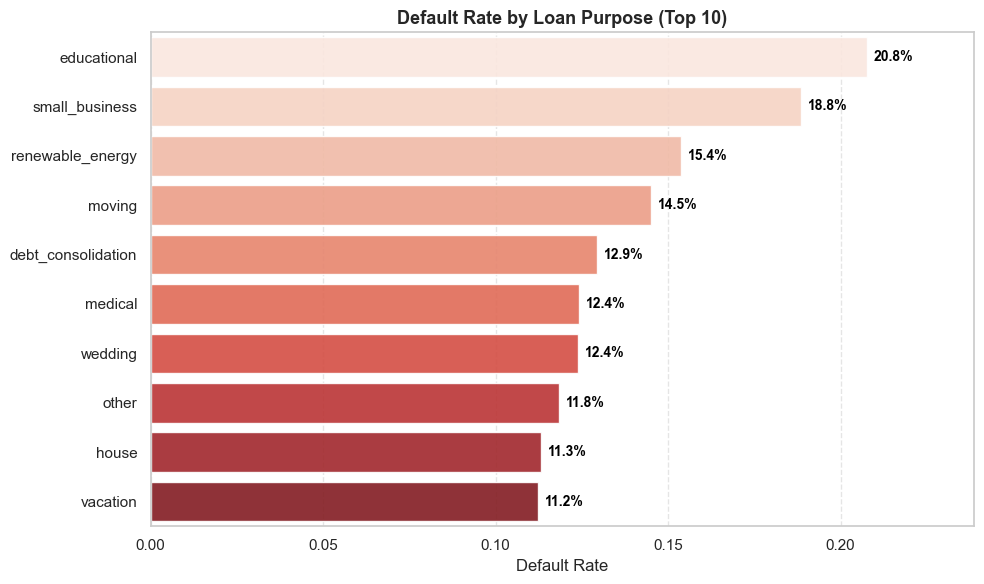

In [23]:
# 5. Default Rate by Loan Purpose 

purpose_default = (
    df.groupby("purpose")["target"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Gradient palette: higher default = darker red
colors = sns.color_palette("Reds", n_colors=len(purpose_default))

ax = sns.barplot(
    x=purpose_default.values,
    y=purpose_default.index,
    palette=colors,
    alpha=0.9,
    edgecolor="white"
)

# Annotate percentage values
for i, v in enumerate(purpose_default.values):
    ax.text(
        v + 0.002, i, f"{v*100:.1f}%",
        va="center", fontsize=10, weight="semibold", color="black"
    )

# Titles and layout
ax.set_title("Default Rate by Loan Purpose (Top 10)", fontsize=13, weight="bold")
ax.set_xlabel("Default Rate")
ax.set_ylabel("")
ax.set_xlim(0, purpose_default.max() * 1.15)
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(FIG_PATH / "default_rate_by_purpose.png", dpi=300, bbox_inches="tight")
plt.show()



/var/folders/g6/cvn07_654_vd6n7331v9tm200000gn/T/ipykernel_94809/4014012333.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


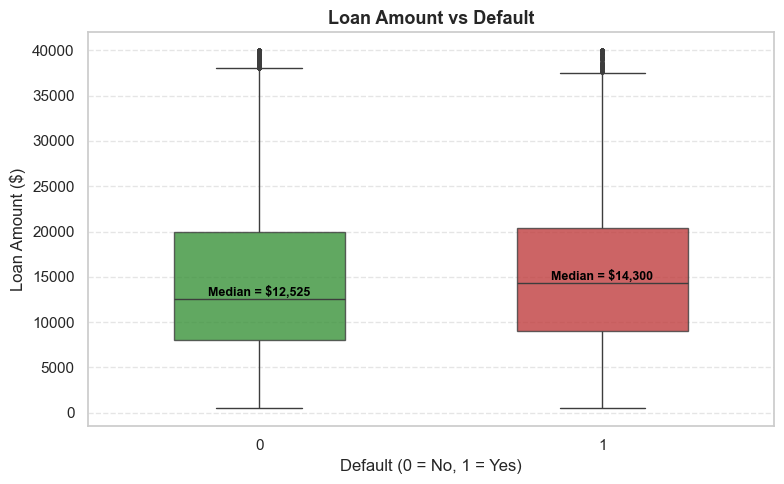

In [24]:
# 6. Loan Amount vs Default 

plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid")

# Draw boxplot with improved palette and transparency
ax = sns.boxplot(
    x="target",
    y="loan_amnt",
    data=df,
    palette=["#2ca02c", "#d62728"],  # green for non-default, red for default
    width=0.5,
    fliersize=2,
    boxprops=dict(alpha=0.8)
)


# Labels and title
ax.set_title("Loan Amount vs Default", fontsize=13, weight="bold")
ax.set_xlabel("Default (0 = No, 1 = Yes)")
ax.set_ylabel("Loan Amount ($)")

# Annotate medians for clarity
medians = df.groupby("target")["loan_amnt"].median()
for xtick in ax.get_xticks():
    median_val = medians[xtick]
    ax.text(
        xtick, median_val, f"Median = ${median_val:,.0f}",
        ha="center", va="bottom", fontsize=9, weight="semibold", color="black"
    )

plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(FIG_PATH / "loan_amnt_vs_default.png", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/g6/cvn07_654_vd6n7331v9tm200000gn/T/ipykernel_94809/2870282954.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


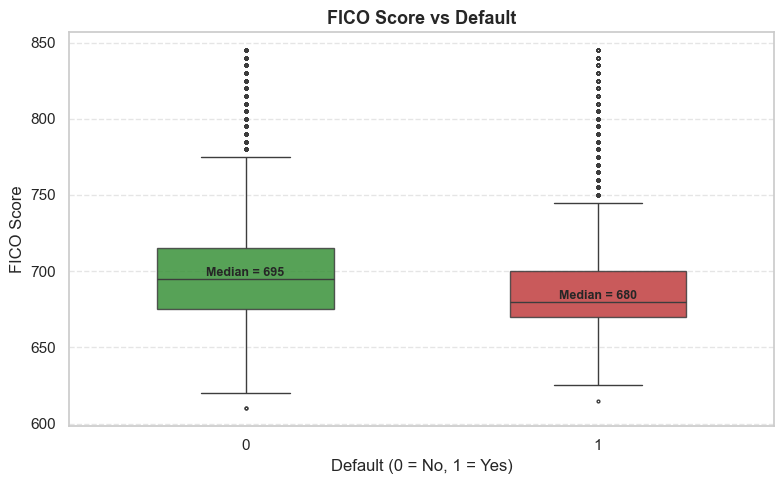

In [25]:
# 7. FICO Score vs Default (Enhanced)

plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid")

ax = sns.boxplot(
    x="target",
    y="fico",
    data=df,
    palette=["#2ca02c", "#d62728"],  # 0 = green (non-default), 1 = red (default)
    width=0.5,
    fliersize=2,
    boxprops=dict(alpha=0.85),
)

ax.set_title("FICO Score vs Default", fontsize=13, weight="bold")
ax.set_xlabel("Default (0 = No, 1 = Yes)")
ax.set_ylabel("FICO Score")

# Annotate medians
medians = df.groupby("target")["fico"].median()
for xtick in ax.get_xticks():
    m = medians[xtick]
    ax.text(xtick, m, f"Median = {m:.0f}", ha="center", va="bottom", fontsize=9, weight="semibold")


plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(FIG_PATH / "fico_vs_default.png", dpi=300, bbox_inches="tight")
plt.show()



#### C. Macroeconomic Trends

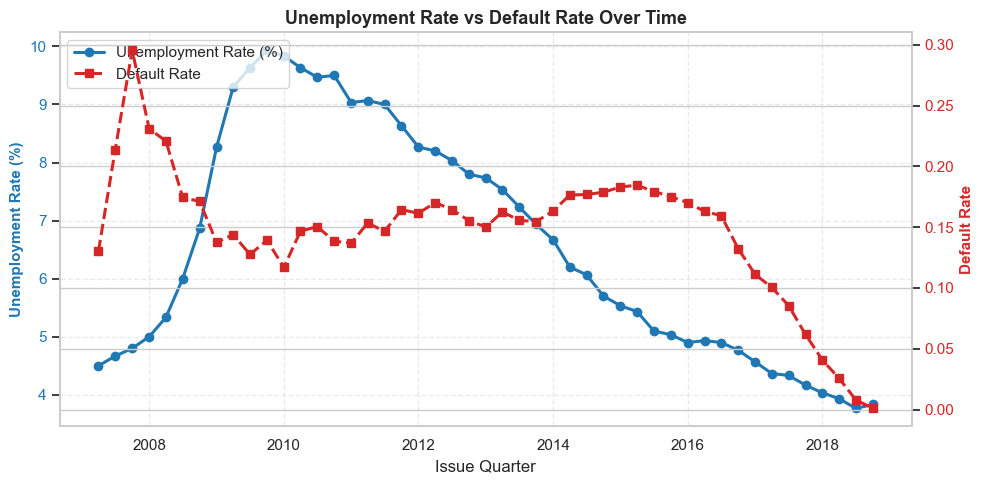

In [26]:
# 8. Unemployment Rate vs Default Rate (Quarterly)

agg = df.groupby("issue_q_start").agg(
    unrate=("UNRATE", "mean"),
    default_rate=("target", "mean")
).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid")

# Primary axis (Unemployment Rate)
ax1.plot(
    agg["issue_q_start"], agg["unrate"],
    color="#1f77b4", linewidth=2.2, marker="o", label="Unemployment Rate (%)"
)
ax1.set_ylabel("Unemployment Rate (%)", color="#1f77b4", fontsize=11, weight="bold")
ax1.tick_params(axis="y", labelcolor="#1f77b4")

# Secondary axis (Default Rate)
ax2 = ax1.twinx()
ax2.plot(
    agg["issue_q_start"], agg["default_rate"],
    color="#d62728", linewidth=2.2, marker="s", linestyle="--", label="Default Rate"
)
ax2.set_ylabel("Default Rate", color="#d62728", fontsize=11, weight="bold")
ax2.tick_params(axis="y", labelcolor="#d62728")

# Styling and annotations
ax1.set_xlabel("Issue Quarter")
ax1.set_title("Unemployment Rate vs Default Rate Over Time", fontsize=13, weight="bold")
ax1.grid(True, linestyle="--", alpha=0.4)

# Unified legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left", frameon=True)

plt.tight_layout()
plt.savefig(FIG_PATH / "unrate_vs_default.png", dpi=300, bbox_inches="tight")
plt.show()



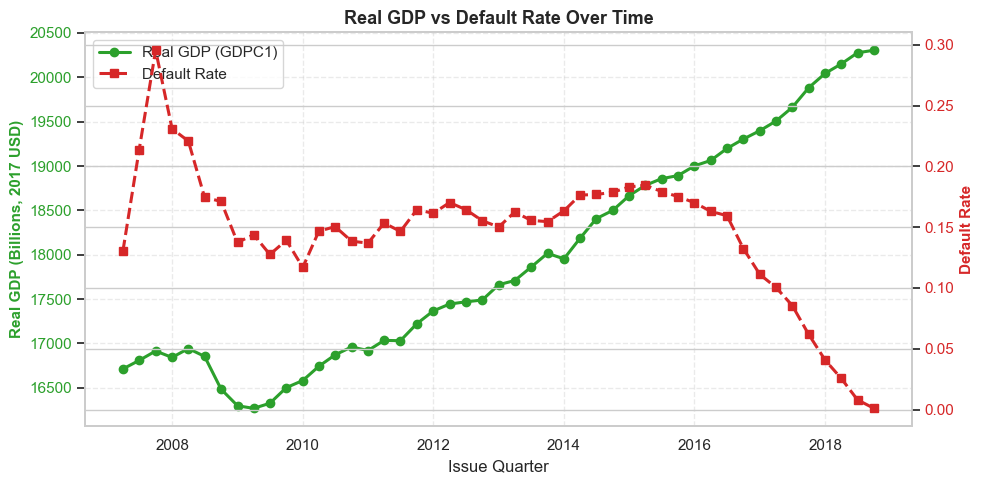

In [27]:
# 9. GDP vs Default Rate (Quarterly, Enhanced)

agg = df.groupby("issue_q_start").agg(
    gdp=("GDPC1", "mean"),
    default_rate=("target", "mean")
).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid")

# Primary axis (Real GDP)
ax1.plot(
    agg["issue_q_start"], agg["gdp"],
    color="#2ca02c", linewidth=2.2, marker="o", label="Real GDP (GDPC1)"
)
ax1.set_ylabel("Real GDP (Billions, 2017 USD)", color="#2ca02c", fontsize=11, weight="bold")
ax1.tick_params(axis="y", labelcolor="#2ca02c")

# Secondary axis (Default Rate)
ax2 = ax1.twinx()
ax2.plot(
    agg["issue_q_start"], agg["default_rate"],
    color="#d62728", linewidth=2.2, marker="s", linestyle="--", label="Default Rate"
)
ax2.set_ylabel("Default Rate", color="#d62728", fontsize=11, weight="bold")
ax2.tick_params(axis="y", labelcolor="#d62728")

# Titles and styling
ax1.set_xlabel("Issue Quarter")
ax1.set_title("Real GDP vs Default Rate Over Time", fontsize=13, weight="bold")
ax1.grid(True, linestyle="--", alpha=0.4)

# Unified legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left", frameon=True)

plt.tight_layout()
plt.savefig(FIG_PATH / "gdp_vs_default.png", dpi=300, bbox_inches="tight")
plt.show()


#### D. Feature Relationships

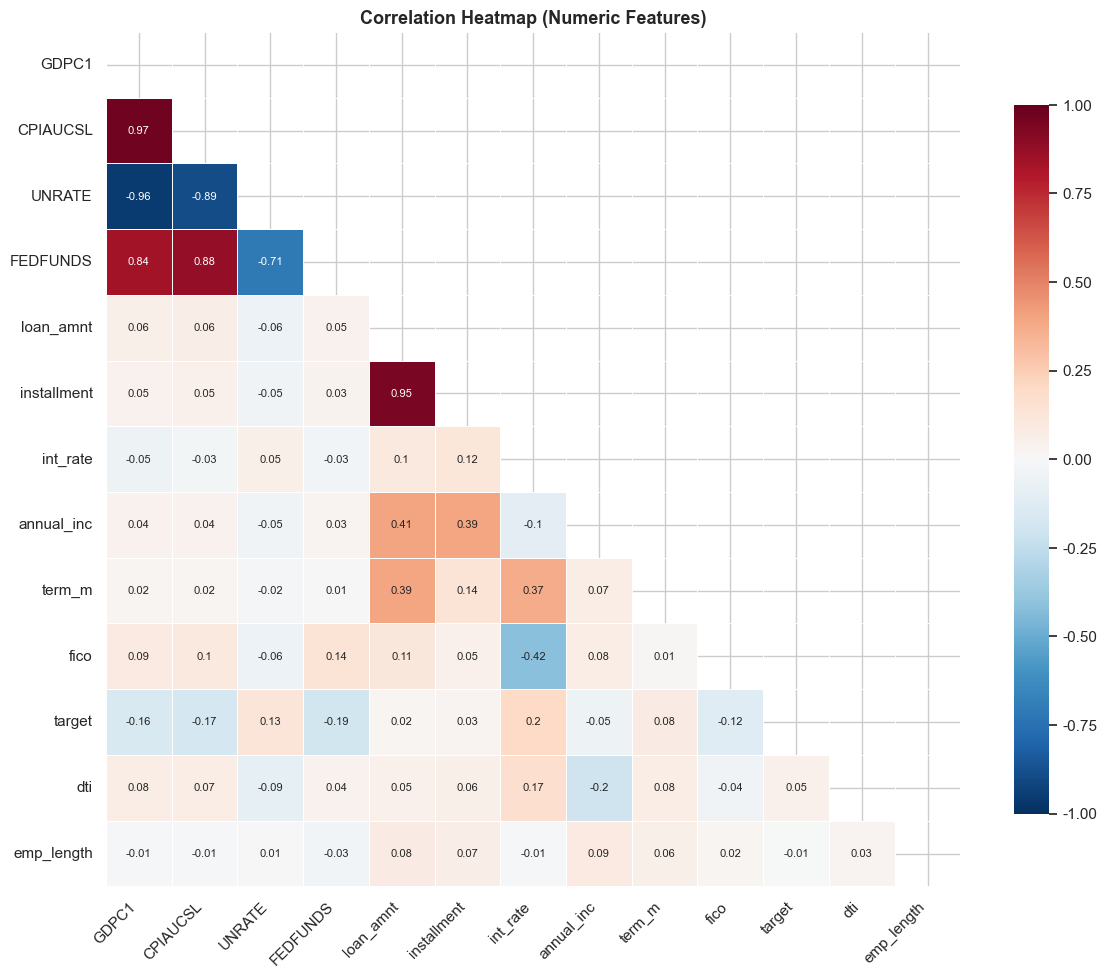

In [28]:
# 10. Correlation Heatmap 

# Select numeric columns (drop obvious IDs if present)
num = df.select_dtypes(include=[np.number]).copy()
for col in ["id"]:
    if col in num.columns:
        num = num.drop(columns=[col])

# Compute correlation (Pearson); reorder columns by total absolute correlation for readability
corr = num.corr(method="pearson")
order = corr.abs().sum().sort_values(ascending=False).index
corr = corr.loc[order, order]

# Mask the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Annotate meaningful correlations
annot_mat = corr.round(2).astype(str)

plt.figure(figsize=(12, 10))
sns.set_theme(style="whitegrid")

ax = sns.heatmap(
    corr,
    mask=mask,
    cmap="RdBu_r",
    vmin=-1, vmax=1, center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "format": "%.2f"},
    annot=annot_mat,
    fmt="",
    annot_kws={"fontsize": 8}
)

ax.set_title("Correlation Heatmap (Numeric Features)", fontsize=13, weight="bold")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(FIG_PATH / "correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()



### 5. Statistical Hypothesis Testing

In [29]:
tests = []

In [30]:
# --- H1: Loan amount differs by default outcome (t-test)
d1 = df.loc[df["target"]==1,"loan_amnt"]
d0 = df.loc[df["target"]==0,"loan_amnt"]
t1,p1 = stats.ttest_ind(d1,d0, equal_var=False, nan_policy="omit")
tests.append(["t-test: loan_amnt (default vs non-default)", t1, p1,
              "Reject H₀" if p1<0.05 else "Fail to reject H₀",
              "Larger loans may have different default behavior."])

In [31]:
# --- H2: Employment length independent of default (Chi-square)

tbl = pd.crosstab(df["emp_length"], df["target"])
chi2,p2,dof2,_ = stats.chi2_contingency(tbl)
tests.append(["χ²: emp_length vs default", chi2, p2,
              "Reject H₀" if p2<0.05 else "Fail to reject H₀",
              "Employment stability linked to repayment likelihood."])

In [32]:
# --- H3: UNRATE correlates with default rate (Pearson r)
agg = df.groupby("issue_q_start").agg(unrate=("UNRATE","mean"),
                                      default_rate=("target","mean"))
r3,p3 = stats.pearsonr(agg["unrate"], agg["default_rate"])
tests.append(["Pearson r: UNRATE vs default rate", r3, p3,
              "Reject H₀" if p3<0.05 else "Fail to reject H₀",
              "Higher unemployment tends to coincide with higher defaults."])


In [33]:
# --- H4: DTI ratio vs default (t-test)
dti1 = df.loc[df["target"]==1,"dti"]
dti0 = df.loc[df["target"]==0,"dti"]
t4,p4 = stats.ttest_ind(dti1,dti0, equal_var=False, nan_policy="omit")
tests.append(["t-test: DTI (default vs non-default)", t4, p4,
              "Reject H₀" if p4<0.05 else "Fail to reject H₀",
              "Higher indebtedness may drive default risk."])


In [34]:
# --- H5: Grade alignment with FICO (ANOVA)
groups = [grp["fico"].dropna() for _,grp in df.groupby("grade")]
f5,p5 = stats.f_oneway(*groups)
tests.append(["ANOVA: FICO across grades", f5, p5,
              "Reject H₀" if p5<0.05 else "Fail to reject H₀",
              "LendingClub grade generally tracks borrower credit quality."])


In [35]:
# --- Save outputs
df_out = pd.DataFrame(tests, columns=["Test","Statistic","p-value","Decision","Interpretation"])
if out_csv.exists():
    df_out.to_csv(out_csv, mode="a", header=False, index=False)
else:
    df_out.to_csv(out_csv, index=False)


In [36]:
# Append to Markdown summary
with out_md.open("a", encoding="utf-8") as f:
    f.write("\n\n---\n")
    f.write(f"## Hypothesis Testing Summary ({TS})\n\n")
    f.write(df_out.to_markdown(index=False))
    f.write("\n")


In [37]:
print(f"Saved results to {out_csv} and appended summary to {out_md}")
df_out

Saved results to ../results/tables/hypothesis_tests.csv and appended summary to ../results/data_quality_report.md


,Test,Statistic,p-value,Decision,Interpretation
0,t-test: loan_amnt (default vs non-default),31.370814,1.002839e-215,Reject H₀,Larger loans may have different default behavior.
1,χ²: emp_length vs default,671.456808,8.393391e-138,Reject H₀,Employment stability linked to repayment likel...
2,Pearson r: UNRATE vs default rate,0.190907,1.986492e-01,Fail to reject H₀,Higher unemployment tends to coincide with hig...
3,t-test: DTI (default vs non-default),78.995399,0.000000e+00,Reject H₀,Higher indebtedness may drive default risk.
4,ANOVA: FICO across grades,116229.569278,0.000000e+00,Reject H₀,LendingClub grade generally tracks borrower cr...
